# 소비자 데이터를 바탕으로 고객의 제품 총 소비량 예측

## 1. 데이터 불러오기

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(train.shape)
train.head(5)

(1108, 22)


,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,8,7,0,0,0,0,0,0,0,541
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,7,1,1,0,0,0,0,0,0,899
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,9,3,0,0,0,0,0,0,0,901
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,3,8,0,0,0,0,0,0,0,50
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,5,7,0,0,0,1,0,0,0,444


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Dt_Customer          1108 non-null   object 
 8   Recency              1108 non-null   int64  
 9   NumDealsPurchases    1108 non-null   int64  
 10  NumWebPurchases      1108 non-null   int64  
 11  NumCatalogPurchases  1108 non-null   int64  
 12  NumStorePurchases    1108 non-null   int64  
 13  NumWebVisitsMonth    1108 non-null   int64  
 14  AcceptedCmp3         1108 non-null   int64  
 15  AcceptedCmp4         1108 non-null   i

### 데이터 전처리

In [3]:
# Dt_customer 열을 y,m,d로 분리
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.Dt_Customer:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
        
    return year, month, day

day, month, year = seperate_datetime(train)
train['year'] = year
train['month'] = month
train['day'] = day

day, month, year = seperate_datetime(test)
test['year'] = year
test['month'] = month
test['day'] = day

In [4]:
train_T=train['target']
target=[]
for i in range(len(train_T)):
    if train_T.iloc[i] < 250:
        target.append(1)
    elif train_T.iloc[i] < 1000:
        target.append(2)
    elif train_T.iloc[i] < 1800:
        target.append(3)
    else:
        target.append(4)
        
train["Range"] = target

In [5]:
# from sklearn.preprocessing import RobustScaler

# train['Year_Birth'] = RobustScaler().fit_transform(train[['Year_Birth']])
# test['Year_Birth'] = RobustScaler().fit_transform(test[['Year_Birth']])

#### Year_Birth 이상치를 가장 많은 빈도수의 값으로 치환

In [6]:
def modifyYBirth_to_maxCnt(dataFrame):
    dicYear = dict(dataFrame['Year_Birth'].value_counts().items())
    maxYearCnt = max(dicYear, key=dicYear.get)
    print(maxYearCnt)
    for idx, year in enumerate(dataFrame.Year_Birth):
        if year <= 1900:
            dataFrame['Year_Birth'][idx] = maxYearCnt
    
    return dataFrame

train = modifyYBirth_to_maxCnt(train)
test = modifyYBirth_to_maxCnt(test)

1971
1976


In [7]:
# def modifyIQRYear_Birth(dataFrame):
#     mean = round(dataFrame['Year_Birth'].mean())
#     for idx, year in enumerate(dataFrame.Year_Birth):
#         if year <= 1900:
#             dataFrame['Year_Birth'][idx] = mean
    
#     return dataFrame

# train = modifyIQRYear_Birth(train)
# test = modifyIQRYear_Birth(test)

#### 출생년도를 계산해 나이 컬럼 추가

In [8]:
train['Age'] = 2022 - train['Year_Birth']
test['Age'] = 2022 - test['Year_Birth']

#### Education, Marital_Status 정수 및 Binary 인코딩

In [9]:
#train set 및 test set에 적용
for data in [train, test]:
    for i in range(data.shape[0]):
        education = data['Education'].iloc[i]
        if education in ["Basic", "Graduation"]:
            data['Education'].iloc[i] = 0
        elif education in ["2n Cycle", "Master"]:
            data['Education'].iloc[i] = 1
        else:
            data['Education'].iloc[i] = 2

In [10]:
#train set 및 test set에 적용
for data in [train, test]:
    for i in range(data.shape[0]):
        marital_status = data['Marital_Status'].iloc[i]
        if marital_status in ["Married", "Together"]:
            data['Marital_Status'].iloc[i] = 0
        else:
            data['Marital_Status'].iloc[i] = 1

#### 캠페인 참여 수 Total 컬럼 추가

In [11]:
train["TotalAcceptedCmp"] = train["AcceptedCmp1"] + train["AcceptedCmp2"] + train["AcceptedCmp3"] + train["AcceptedCmp4"] + train["AcceptedCmp5"] + train["Response"]
test["TotalAcceptedCmp"] = test["AcceptedCmp1"] + test["AcceptedCmp2"] + test["AcceptedCmp3"] + test["AcceptedCmp4"] + test["AcceptedCmp5"] + test["Response"]

#### 구매횟수 통합

In [12]:
train['TotalPurchases'] = train['NumCatalogPurchases']+train['NumStorePurchases']+train['NumWebPurchases']
test['TotalPurchases'] = test['NumCatalogPurchases']+test['NumStorePurchases']+test['NumWebPurchases']

# train['RCatalogPurchases'] = train['NumCatalogPurchases'] / train['TotalPurchases']
# train['RStorePurchases'] = train['NumStorePurchases'] / train['TotalPurchases']
# train['RWebPurchases'] = train['NumWebPurchases'] / train['TotalPurchases']

#### 자녀 수 통합

In [13]:
train['Dependents'] = train['Kidhome'] + train['Teenhome']
test['Dependents'] = test['Kidhome'] + test['Teenhome']

#### 상관관계

Text(0.5, 1.0, 'Correlation between features')

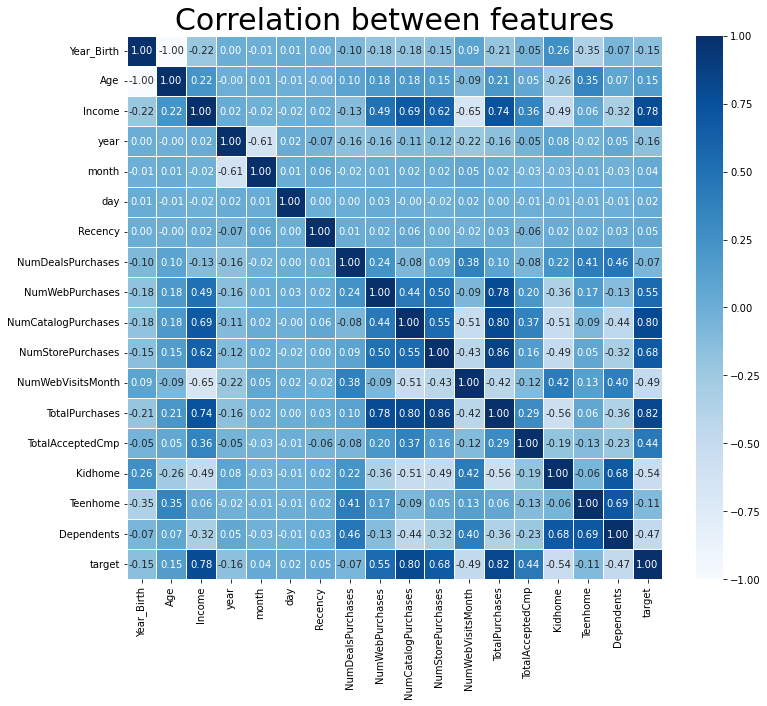

In [14]:
# 수치형 데이터 상관관계 히트맵 시각화
from sklearn.preprocessing import MinMaxScaler
quantitative = ['Year_Birth', 'Age','Income', 'year',	'month', 'day', 'Recency',
                'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
               'TotalPurchases', 'TotalAcceptedCmp', 'Kidhome', 'Teenhome', 'Dependents','target']

train_corr = train[quantitative]
scaler= MinMaxScaler()
train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])
corr28 = train_corr.corr(method= 'pearson')

plt.figure(figsize=(12,10))
sns.heatmap(data = corr28, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)

In [15]:
corr_matrix = train.corr()
corr_matrix["target"].sort_values(ascending=False)

target                 1.000000
Range                  0.954404
TotalPurchases         0.823537
NumCatalogPurchases    0.798065
Income                 0.784084
NumStorePurchases      0.677785
NumWebPurchases        0.546082
AcceptedCmp5           0.458208
TotalAcceptedCmp       0.444114
AcceptedCmp1           0.361102
AcceptedCmp4           0.256784
Response               0.242760
Age                    0.151380
AcceptedCmp2           0.129995
Recency                0.050873
AcceptedCmp3           0.040736
month                  0.037649
id                     0.034192
day                    0.018917
Complain              -0.058704
NumDealsPurchases     -0.072802
Teenhome              -0.109214
Year_Birth            -0.151380
year                  -0.159404
Dependents            -0.471012
NumWebVisitsMonth     -0.488252
Kidhome               -0.538365
Name: target, dtype: float64

#### 필요없는 열 정리

In [16]:
train = train.drop(["Dt_Customer", "Year_Birth", "month", "day", "Recency", "Complain"], axis = 1)
train = train.drop(["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"], axis = 1)
# train = train.drop(["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"], axis = 1)

test = test.drop(["Dt_Customer", "Year_Birth", "month", "day", "Recency", "Complain"], axis = 1)
test = test.drop(["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"], axis = 1)
# test = test.drop(["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"], axis = 1)

In [17]:
train.head()

,id,Education,Marital_Status,Income,Kidhome,Teenhome,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,target,year,Range,Age,TotalAcceptedCmp,TotalPurchases,Dependents
0,0,1,0,46014.0,1,1,10,7,1,8,7,541,2013,2,48,0,16,2
1,1,0,1,76624.0,0,1,1,5,10,7,1,899,2014,2,60,1,22,1
2,2,0,0,75903.0,0,1,2,6,6,9,3,901,2013,2,71,0,21,1
3,3,0,0,18393.0,1,0,2,3,0,3,8,50,2014,1,48,0,6,1
4,4,2,0,64014.0,2,1,7,8,2,5,7,444,2014,2,76,1,15,3


In [18]:
train.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Education            1108 non-null   object 
 2   Marital_Status       1108 non-null   object 
 3   Income               1108 non-null   float64
 4   Kidhome              1108 non-null   int64  
 5   Teenhome             1108 non-null   int64  
 6   NumDealsPurchases    1108 non-null   int64  
 7   NumWebPurchases      1108 non-null   int64  
 8   NumCatalogPurchases  1108 non-null   int64  
 9   NumStorePurchases    1108 non-null   int64  
 10  NumWebVisitsMonth    1108 non-null   int64  
 11  target               1108 non-null   int64  
 12  year                 1108 non-null   int64  
 13  Range                1108 non-null   int64  
 14  Age                  1108 non-null   int64  
 15  TotalAcceptedCmp     1108 non-null   i

In [19]:
test.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Education            1108 non-null   object 
 2   Marital_Status       1108 non-null   object 
 3   Income               1108 non-null   float64
 4   Kidhome              1108 non-null   int64  
 5   Teenhome             1108 non-null   int64  
 6   NumDealsPurchases    1108 non-null   int64  
 7   NumWebPurchases      1108 non-null   int64  
 8   NumCatalogPurchases  1108 non-null   int64  
 9   NumStorePurchases    1108 non-null   int64  
 10  NumWebVisitsMonth    1108 non-null   int64  
 11  year                 1108 non-null   int64  
 12  Age                  1108 non-null   int64  
 13  TotalAcceptedCmp     1108 non-null   int64  
 14  TotalPurchases       1108 non-null   int64  
 15  Dependents           1108 non-null   i

### 훈련 데이터 분할 및 모델 학습

In [20]:
data_train_X = train.drop(['id', 'target'], axis = 1) #training 데이터에서 피쳐 추출
data_train_y = train.target #training 데이터에서 소비량 추출
test = test.drop(['id'], axis = 1)

In [21]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import GradientBoostingRegressor

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True) #총 10번의 fold 진행
n = 0 #x번째 fold인지 기록

fold_target_pred = []
fold_score = []

# param_rf = {'n_estimators':[300, 500], 'max_depth': [8,16], 'min_samples_split': [8,16], 'min_samples_leaf' :[8,16],'criterion':['mae'],'random_state':[42]}
# param_xgb = {'n_estimators':[300,500], 'max_depth': [8,16],'random_state':[42]}
# param_cat = {'n_estimators':[1200], 'max_depth': [8,16], 'silent': [True],'random_state':[42]}


for train_index, valid_index in skf.split(train, train['Range']): #range 기준으로 stratified k fold 진행
    n += 1

    val_pred_name = []
    val_pred = []      #validation set pred 결과 저장
    target_pred = []   #test set pred 결과 저장
    
    train_X = np.array(data_train_X.drop("Range", axis = 1)) #분배된 학습을 위해 생성한 Range feature 제거
    train_Y = np.array(data_train_y)
    
    X_train, X_valid = train_X[train_index], train_X[valid_index]
    y_train, y_valid = train_Y[train_index], train_Y[valid_index]
    
    X_test = np.array(test)

    ### Create Model ###
    
    ### RandomForestRegressor ###
    model = RandomForestRegressor(n_estimators=500, max_depth=16, random_state=42, criterion='mae') #추가적으로 하이퍼파라미터 튜닝 필요
#     grid_search = GridSearchCV(model, param_rf, cv=5)
#     grid_search.fit(X_train, y_train)
#     print("RandomForestRegressor best param is : ", grid_search.best_params_)
#     model = grid_search.best_estimator_
    model.fit(X_train, y_train) # 모델 학습
    
    val_pred_name.append("RandomForestRegressor")      # 모델 이름 저장
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    ### XGBRegressor ###
    model = XGBRegressor(n_estimators=200, max_depth=8, random_state=42) #추가적으로 하이퍼파라미터 튜닝 필요
#     grid_search = GridSearchCV(model, param_xgb, cv=5)
#     grid_search.fit(X_train, y_train)
#     print("XGBRegressor best param is : ", grid_search.best_params_)
#     model = grid_search.best_estimator_
    model.fit(X_train, y_train)
    
    val_pred_name.append("XGBRegressor")
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    ### CatBoostRegressor ###
    model = CatBoostRegressor(n_estimators=1200, max_depth=8, random_state=42, verbose=0) #추가적으로 하이퍼파라미터 튜닝 필요
#     grid_search = GridSearchCV(model, param_cat, cv=5)
#     grid_search.fit(X_train, y_train)
#     print("CatBoostRegressor best param is : ", grid_search.best_params_)
#     model = grid_search.best_estimator_
    model.fit(X_train, y_train)
    
    val_pred_name.append("CatBoostRegressor")
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    

    ### voting ###
    ### average validation pred ###
    preds = np.array(val_pred[0])
    for i in range(1, len(val_pred)):
        preds += val_pred[i]
    
    preds = preds/len(val_pred)
    
    ### average target pred ###
    target_preds = np.array(target_pred[0])
    for i in range(1, len(target_pred)):
        target_preds += target_pred[i]
    
    target_preds = target_preds/len(target_pred)
    print(f"target_preds is {target_preds}")
    
    fold_target_pred.append(target_preds) # append final target pred
    
    print(f"========== fold {n} ==========")
    for i in range(len(val_pred)):
        print(f"{val_pred_name[i]} model NMAE : { NMAE(y_valid, val_pred[i].astype(int))}")
    print("==============================")
    print(f"Average NMAE { NMAE(y_valid, preds.astype(int))}")
    print("")
    
    fold_score.append(NMAE(y_valid, preds.astype(int)))


total_score = fold_score[0]
for i in range(2, len(fold_score), 1):
    total_score += fold_score[i]
total_score = total_score/(len(fold_score))    

print("==============================")
print("Total Average NMAE %0.4f" %(total_score)) #최종 average score 출력

target_preds is [ 542.51302311  854.94371919  820.92931669 ...   71.55524942 1139.28816156
  170.51270031]
========== fold 1 ==========
RandomForestRegressor model NMAE : 0.2289827371742362
XGBRegressor model NMAE : 0.21478413883073938
CatBoostRegressor model NMAE : 0.20518188161766937
Average NMAE 0.21123448924486515

target_preds is [539.91140865 694.67004579 781.64323739 ...  71.44853359 915.83113364
 129.23199162]
========== fold 2 ==========
RandomForestRegressor model NMAE : 0.2046052732841817
XGBRegressor model NMAE : 0.21060813618802815
CatBoostRegressor model NMAE : 0.1856269913343287
Average NMAE 0.1931536578983823

target_preds is [ 529.38427765  795.67746483  853.68417497 ...   69.86125625 1126.47639907
  129.12807988]
========== fold 3 ==========
RandomForestRegressor model NMAE : 0.1409660205495425
XGBRegressor model NMAE : 0.12904509101883482
CatBoostRegressor model NMAE : 0.1432020522106534
Average NMAE 0.1286335514493052

target_preds is [ 523.93963315  760.98556923  7

- GridSearch를 통해 적절한 파라미터를 찾은 후 학습 시간이 오래걸려 직접 파라미터를 설정해줌

In [23]:
### average target pred ###
final_pred = np.array(fold_target_pred[0])
for i in range(1, len(fold_target_pred)):
    final_pred += fold_target_pred[i]

final_pred = final_pred/len(fold_target_pred)
final_pred = final_pred.astype(int)

In [24]:
fold_target_pred

[array([ 542.51302311,  854.94371919,  820.92931669, ...,   71.55524942,
        1139.28816156,  170.51270031]),
 array([539.91140865, 694.67004579, 781.64323739, ...,  71.44853359,
        915.83113364, 129.23199162]),
 array([ 529.38427765,  795.67746483,  853.68417497, ...,   69.86125625,
        1126.47639907,  129.12807988]),
 array([ 523.93963315,  760.98556923,  794.64986587, ...,   74.38689323,
        1110.04126868,  128.83506687]),
 array([ 526.24710682,  704.39761526,  820.6822612 , ...,   72.0448749 ,
        1104.40211811,  129.73739528]),
 array([ 538.66419697,  765.16016105,  861.78822125, ...,   69.30986125,
        1045.57084507,  130.12526319]),
 array([ 581.47513427,  816.84154218,  812.43129205, ...,   70.02382742,
        1110.41672554,  129.12300078]),
 array([ 495.12697291,  873.4642494 ,  847.29562958, ...,   72.73325611,
        1059.91304606,  129.27105018]),
 array([ 486.84056298,  779.01528614,  863.28283651, ...,   74.70948423,
        1138.59214978,  128.8

In [25]:
final_pred

array([ 533,  772,  828, ...,   71, 1078,  133])

In [26]:
submission = pd.read_csv("data/sample_submission.csv")
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [27]:
submission['target'] = final_pred
submission.head()

,id,target
0,0,533
1,1,772
2,2,828
3,3,1286
4,4,1386


In [28]:
submission.to_csv("submission_baseline8.csv",index=False)